![example](images/director_shot.jpeg)

# Microsoft Movie Analysis Summary

**Authors:** David Boyd
***

## Overview

Microsoft is looking to open up their own movie studio, but don't know anything about movies to know where they should invest their efforts in. This project looks at data from various sources, ranging from IMDB, Rotten Tomatoes, Movie Budgets and gathering additional data from Box Office Mojo to understand the answers to the following questions:

- Which genre has the best ROI
- What movie rating gets the best reviews on rotten tomatoes?
- Should they focus on family friendly or non-family friendly movies?
- How long should the movie last?
- Which month of the year is the best to release a movie, both for overall ROI and best opening weekend sales?

We can see that in the US the best genres to produce for ROI are Horror/Thriller movies due to their low production costs. Afterwards, it is mainly Comedy, Romance & Drama films. When looking at gross revenue, we can see that Action/Adventure/Sci-Fi based movies rank highest. The movie ratings with the best Rotten Tomatoes score is NR, followed by R & PG. Movies should last no longer than 135 minutes and the best months to release movies is January & February for opening weekend % of return. For gross revenue, the best month to release is May/June.

## Business Problem

I have been tasked with providing recommendations to Microsoft around what type of movies perform best so they know where to invest their budgets when launching a movie studio to get good returns. In order to do this, I focused on the main questions to be able to answer:

- Which genre has the best ROI
- What movie rating gets the best reviews on rotten tomatoes?
- Should they focus on family friendly or non-family friendly movies?
- How long should the movie last?
- Which month of the year is the best to release a movie, both for overall ROI and best opening weekend sales?

The reason I chose these questions is because, since Microsoft is new to the industry, it is important to focus on understanding the different metrics and measures that revolve around them being able to make money from their films. This is why focusing on ratings, length of movies, genres and month of release are important, as they all factor into overall return on investment. This is important, as movies are very expensive ventures, so unless they have an ulterior motive (to attract a new demographic, target audience for other products) the business should be profit making.

## Data Understanding

There are a range of sources being used with the data, these range from rating data both from IMDB and Rotten Tomatoes, production & revenue values from The Numbers movie budgets and opening weekend revenue from Box Office Mojo. Across these different sources we're able to calculate metrics around movie ratings, ROI, time in cinema, genres, runtime which can be used to answer the questions set above.


In [6]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

%matplotlib inline
from src import boxmojo_scraping as scrap

# Functions to use

In [3]:
def explore_dataframe(dataframe):
    ''' This function is used to explore each
    dataframe to understand it's shape, datatypes
    , if there are missing/null values
    and a few records
    '''
    print(dataframe.shape)
    print(dataframe.info())
    print(dataframe.head())
    
def generate_primary_key(dataframe):
    '''This function generates a primary key by
    removing all spaces from the movie titles, this will be used
    later in the analysis to join different datasets together'''
    dataframe['key'] = dataframe['movie_title'].replace(" ", "", regex=True)
    return dataframe

def drop_columns(dataframe, columns_to_drop):
    '''This function is used to drop columns from listed dataframes'''
    return dataframe.drop(columns_to_drop, axis=1, inplace=True)

def convert_datatype(dataframe, datatype_dict):
    '''The function takes a dataframe and converts the columns according to an inputted 
    dictionary which includes the column name as key and desired data type as the value'''
    dataframe = dataframe.astype(datatype_dict)
    return dataframe

def convert_to_datetime(dataframe, column, date_format):
    '''This function takes a dataframe, a specific column and a date format to convert it into
    a datetime column'''
    dataframe[column] = pd.to_datetime(dataframe[column], format=date_format)
    return dataframe.head()

def agg_rt_func(dataframe):
    '''This function takes a dataframe and creates a series of a dictionary
    used to generate different aggregations specified inside. This will be used on the Rotten Tomatoes Reviews
    dataset'''
    aggregate_names = {
        'total_count_of_reviews': dataframe['fresh'].count(),
        'total_count_of_fresh_reviews': dataframe[dataframe['fresh'] == 'fresh']['fresh'].count(),
        'total_count_of_critic_reviews': dataframe[dataframe['critic'].notnull()]['fresh'].count(),
        'total_count_of_fresh_critic_reviews': dataframe[(dataframe['fresh'] == 'fresh') & (dataframe['critic'].notnull())]['fresh'].count(),
        'total_count_of_top_critic_reviews': dataframe[dataframe['top_critic'] == 1]['fresh'].count(),        
        'total_count_of_fresh_top_critic_reviews': dataframe[(dataframe['fresh'] == 'fresh') & (dataframe['top_critic'] == 1)]['fresh'].count()          
}

    return pd.Series(aggregate_names)

# Scraping Box Office Mojo Data

In [4]:
full_data = []
for year in range(1970, 2020):
    full_data.append(scrap.extract_opening_weekend_data(f"https://www.boxofficemojo.com/year/{year}/?grossesOption=totalGrosses&sort=rank&sortDir=asc", year))

opening_weekend_rev_movie_df = pd.DataFrame(sum(full_data,[]), columns = ['movie_title', 'opening_weekend_revenue', 'release_date', 'closing_date', 'year'])
# We generate a dataframe containing the columns extracted using our web scraping script for opening box office data
# for movies from 1970 until 2020

In [7]:
opening_weekend_rev_movie_df['full_release_date'] = opening_weekend_rev_movie_df['release_date'] +", "+ opening_weekend_rev_movie_df['year'].astype(str)

opening_weekend_rev_movie_df['release_month'] = opening_weekend_rev_movie_df['release_date'].str.split(' ').str[0]
opening_weekend_rev_movie_df['closing_month'] = opening_weekend_rev_movie_df['closing_date'].str.split(' ').str[0]
# split apart the date fields to extract month names

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_dict = {month:f"{datetime.strptime(month, '%b').month}" for month in months}
# Creating dictionary to convert month name into month number

opening_weekend_rev_movie_df['release_month'].replace(month_dict, inplace=True)
opening_weekend_rev_movie_df['closing_month'].replace(month_dict, inplace=True)
# Generating month numbers for later transformation

opening_weekend_rev_movie_df[opening_weekend_rev_movie_df['opening_weekend_revenue'] == 'NULL'].count()
# Exploring null values in opening weekend revenue

movie_title                569
opening_weekend_revenue    603
release_date               603
closing_date               603
year                       603
full_release_date          603
release_month              603
closing_month              603
dtype: int64

In [8]:
opening_weekend_rev_movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7834 entries, 0 to 7833
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   movie_title              7677 non-null   object
 1   opening_weekend_revenue  7834 non-null   object
 2   release_date             7834 non-null   object
 3   closing_date             7834 non-null   object
 4   year                     7834 non-null   int64 
 5   full_release_date        7834 non-null   object
 6   release_month            7834 non-null   object
 7   closing_month            7834 non-null   object
dtypes: int64(1), object(7)
memory usage: 489.8+ KB


In [9]:
opening_weekend_rev_movie_df[opening_weekend_rev_movie_df['closing_date'] == '-'].count()
# Currently about half of the records are missing a closing date. Instead of just removing all those records
# we will create a separate DataFrame to calculate the portion we can for time in cinema and join back onto the full
# database for enrichment further down the EDA.

movie_title                3882
opening_weekend_revenue    3969
release_date               3969
closing_date               3969
year                       3969
full_release_date          3969
release_month              3969
closing_month              3969
dtype: int64

In [10]:
non_empty_closing_date = opening_weekend_rev_movie_df[opening_weekend_rev_movie_df['closing_month'] != '-']
non_empty_closing_date['month_diff'] = non_empty_closing_date['closing_month'].astype(int) - non_empty_closing_date['release_month'].astype(int)
# calculating month_difference to accurately assign closing_date with correct year

non_empty_closing_date['full_closing_date'] = non_empty_closing_date['closing_date'] + ", " + non_empty_closing_date['year'].astype(str)
condition = non_empty_closing_date['month_diff'] < 0.0
non_empty_closing_date.loc[condition, 'full_closing_date'] = non_empty_closing_date['closing_date'] + ", " + (non_empty_closing_date['year'] + 1).astype(str)

<ipython-input-10-4ab68293cc7c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_empty_closing_date['month_diff'] = non_empty_closing_date['closing_month'].astype(int) - non_empty_closing_date['release_month'].astype(int)
<ipython-input-10-4ab68293cc7c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_empty_closing_date['full_closing_date'] = non_empty_closing_date['closing_date'] + ", " + non_empty_closing_date['year'].astype(str)
/Users/davidboyd/opt/anaconda3/envs/learn-env/lib/python3.8/site-pac

In [11]:
non_empty_closing_date.head()
non_empty_closing_date = non_empty_closing_date[non_empty_closing_date['closing_date'] != 'Feb 29']
# Removing potential leap year closing dates

non_empty_closing_date['release_date_time'] = pd.to_datetime(non_empty_closing_date['full_release_date'], format='%b %d, %Y')
convert_to_datetime(non_empty_closing_date, 'full_closing_date' ,'%b %d, %Y')
# creating datetime datatypes for release_date and closing_date

non_empty_closing_date['time_between_release_and_closing'] = non_empty_closing_date['full_closing_date'] - non_empty_closing_date['release_date_time']  
# calculates number of days movie was in the cinema

non_empty_closing_date['key'] = non_empty_closing_date['movie_title'].replace(" ", "", regex=True)
opening_weekend_rev_movie_df['key'] = opening_weekend_rev_movie_df['movie_title'].replace(" ", "", regex=True)
# creates key field to enable self joins

full_opening_weekend_rev_movie_df = opening_weekend_rev_movie_df.merge(non_empty_closing_date, on=['key','full_release_date'], how='left', suffixes=('_left', '_right'))

In [12]:
full_opening_weekend_rev_movie_df.info()
# Complete scraped data dataframe, ready for cleaning

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7838 entries, 0 to 7837
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype          
---  ------                            --------------  -----          
 0   movie_title_left                  7677 non-null   object         
 1   opening_weekend_revenue_left      7838 non-null   object         
 2   release_date_left                 7838 non-null   object         
 3   closing_date_left                 7838 non-null   object         
 4   year_left                         7838 non-null   int64          
 5   full_release_date                 7838 non-null   object         
 6   release_month_left                7838 non-null   object         
 7   closing_month_left                7838 non-null   object         
 8   key                               7677 non-null   object         
 9   movie_title_right                 3793 non-null   object         
 10  opening_weekend_revenue_right     38

# Reading in other data sources

In [13]:
df_rt_movie_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', delimiter= '\t')
# contains Rotten Tomatoes movie info

df_rt_reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', delimiter= '\t', encoding='latin-1')
# contains Rotten Tomatoes movie ratings

df_tn_movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
df_tn_movie_budgets.rename({'movie':'movie_title'}, axis=1, inplace=True)
# contains production budgets & gross revenues

In [14]:
from zipfile import ZipFile

with ZipFile('zippedData/im.db.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('zippedData')

In [15]:
import sqlite3

conn = sqlite3.connect('zippedData/im.db')

all_data_query = """
WITH base_query AS (
SELECT DISTINCT
m.*
, REPLACE(m.primary_title, " ","") AS key
, p.primary_name AS director_name
, mr.averagerating AS average_rating
, mr.numvotes AS number_of_votes
, row_number() OVER (PARTITION BY REPLACE(m.primary_title, " ","") ORDER BY REPLACE(m.primary_title, " ","")) AS rn
FROM movie_basics AS m
LEFT JOIN directors AS d
    ON m.movie_id = d.movie_id
JOIN persons AS p
    ON d.person_id = p.person_id
LEFT JOIN movie_akas AS ma
    ON m.movie_id = ma.movie_id
LEFT JOIN movie_ratings as mr
    ON m.movie_id = mr.movie_id
WHERE ma.region = 'US')

SELECT 
*
FROM base_query
WHERE rn = 1
;
"""

df_imdb_data = pd.read_sql(all_data_query, conn)

In [16]:
df_imdb_data.describe()
df_imdb_data = df_imdb_data[df_imdb_data['runtime_minutes'] < 240]
# removing outliers in dataset with erroneous runtimes
df_imdb_data.describe()

,start_year,runtime_minutes,average_rating,number_of_votes,rn
count,37207.000000,37207.000000,23501.000000,2.350100e+04,37207.0
mean,2013.941086,82.996318,6.226063,9.136092e+03,1.0
std,2.516467,25.903800,1.576156,5.186088e+04,0.0
min,2010.000000,1.000000,1.000000,5.000000e+00,1.0
25%,2012.000000,71.000000,5.200000,1.800000e+01,1.0
50%,2014.000000,86.000000,6.400000,8.200000e+01,1.0
75%,2016.000000,96.000000,7.400000,6.320000e+02,1.0
max,2021.000000,239.000000,10.000000,1.841066e+06,1.0


In [17]:
df_imdb_data[df_imdb_data['rn'] != 1]
# Checking no duplicate entries have been made for each movie, otherwise when joining onto other data sources
# we would start duplicating our data and causing errors

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,key,director_name,average_rating,number_of_votes,rn


# Exploring datasets

In [18]:
all_dataframes = [df_rt_movie_info, df_rt_reviews, df_tn_movie_budgets, df_imdb_data]

for dataframe in all_dataframes:
    explore_dataframe(dataframe)

(1560, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB
None
   id                                           synopsis rating  \
0   1  This gritty, fast-paced, and innovative police...      R   
1   3  New York City, not-too-distant-future: Eric Pa...      R   
2   5  Illeana Douglas delivers a s

In [19]:
for dataframe in all_dataframes:
    try:
        generate_primary_key(dataframe)
    except:
        continue

In [20]:
df_tn_movie_budgets.head()
# checking primary key field has been added correctly

,id,release_date,movie_title,production_budget,domestic_gross,worldwide_gross,key
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",Avatar
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",PiratesoftheCaribbean:OnStrangerTides
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",DarkPhoenix
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",Avengers:AgeofUltron
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",StarWarsEp.VIII:TheLastJedi


## Data Preparation

To prepare the data, each dataset had it's own set of requirements, whether it was drop some columns, as they either didn't have enough data in them, or they weren't relevant to the questions I was trying to answer. Reformat columns and change datatypes from objects to either integers, or datetime. To make the code cleaner, all of the necessary commands were added into a seprate python script to be imported and ran below.

There were some outliers in the IMDB data when it came to the runtime field, these were handled by excluding all values which went above a reasonable figure of 4 hours, as everything else is unrealistic and likely a data entry error.

# Dropping unnecessary columns

In [21]:
open_weekend_columns_to_drop = ['release_date_left', 'closing_date_left', 'release_month_left', 'closing_month_left'
                               , 'movie_title_right', 'opening_weekend_revenue_right', 'release_date_right'
                               , 'closing_date_right', 'year_right', 'release_month_right', 'closing_month_right'
                               , 'month_diff', 'release_date_time']
drop_columns(full_opening_weekend_rev_movie_df, open_weekend_columns_to_drop)

drop_columns(df_rt_movie_info, ['synopsis','currency', 'box_office', 'runtime', 'studio'])

drop_columns(df_rt_reviews, ['review', 'publisher', 'date'])

drop_columns(df_imdb_data, ['original_title'])

# Data cleaning - The Numbers movie budgets
From exploring the data set, we can see multiple columns that need to be cleaned, first to convert the release date into a datetime format. Then to remove all unnecessary special characters from production budget, domestic gross and worldwide gross to convert into integer values. The code below achieves these steps.

In [22]:
convert_to_datetime(df_tn_movie_budgets, 'release_date', '%b %d, %Y')

df_tn_movie_budgets['production_budget'].replace('\W+','',regex=True, inplace=True)
df_tn_movie_budgets['domestic_gross'].replace('\W+','',regex=True, inplace=True)
df_tn_movie_budgets['worldwide_gross'].replace('\W+','',regex=True, inplace=True)
# removing special characters

df_tn_movie_budgets = convert_datatype(df_tn_movie_budgets, {"production_budget":"int", "domestic_gross":"int", "worldwide_gross":"int"})
# converting to integers

df_tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie_title        5782 non-null   object        
 3   production_budget  5782 non-null   int64         
 4   domestic_gross     5782 non-null   int64         
 5   worldwide_gross    5782 non-null   int64         
 6   key                5782 non-null   object        
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 316.3+ KB


# Data Cleaning - Scraped data

For the opening weekend revenue dataset that was scraped from the Box Office Mojo site, we need to update release date into a datetime datatype and handle NULL movie titles & opening weekend revenues before converting it into integer values, for later aggregations

In [23]:
convert_to_datetime(full_opening_weekend_rev_movie_df, 'full_release_date' ,'%b %d, %Y')

full_opening_weekend_rev_movie_df[full_opening_weekend_rev_movie_df['opening_weekend_revenue_left'] == 'NULL'].head()
# checking to see if there are any null revenue records

full_opening_weekend_rev_movie_df['opening_weekend_revenue_left'] = full_opening_weekend_rev_movie_df['opening_weekend_revenue_left'].replace('NULL', 0)
# removing null revenue values to convert datatype

full_opening_weekend_rev_movie_df['opening_weekend_revenue_left'].astype(int)

full_opening_weekend_rev_movie_df.info()
# From the info chart below we can see there are still some missing movie_titles. As we want to use this data to join on, we will remove these records



<class 'pandas.core.frame.DataFrame'>
Int64Index: 7838 entries, 0 to 7837
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype          
---  ------                            --------------  -----          
 0   movie_title_left                  7677 non-null   object         
 1   opening_weekend_revenue_left      7838 non-null   int64          
 2   year_left                         7838 non-null   int64          
 3   full_release_date                 7838 non-null   datetime64[ns] 
 4   key                               7677 non-null   object         
 5   full_closing_date                 3867 non-null   datetime64[ns] 
 6   time_between_release_and_closing  3867 non-null   timedelta64[ns]
dtypes: datetime64[ns](2), int64(2), object(2), timedelta64[ns](1)
memory usage: 489.9+ KB


In [24]:
full_opening_weekend_rev_movie_df = full_opening_weekend_rev_movie_df[full_opening_weekend_rev_movie_df['movie_title_left'] != 'NULL']
full_opening_weekend_rev_movie_df = full_opening_weekend_rev_movie_df[full_opening_weekend_rev_movie_df['movie_title_left'].notnull()]
# ignoring null movie title records

full_opening_weekend_rev_movie_df.info()
# This dataset has now been cleaned of all NULL movie_title values, blank closing_dates and any missing opening weekend revenue has been replaced by a 0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7677 entries, 0 to 7837
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype          
---  ------                            --------------  -----          
 0   movie_title_left                  7677 non-null   object         
 1   opening_weekend_revenue_left      7677 non-null   int64          
 2   year_left                         7677 non-null   int64          
 3   full_release_date                 7677 non-null   datetime64[ns] 
 4   key                               7677 non-null   object         
 5   full_closing_date                 3793 non-null   datetime64[ns] 
 6   time_between_release_and_closing  3793 non-null   timedelta64[ns]
dtypes: datetime64[ns](2), int64(2), object(2), timedelta64[ns](1)
memory usage: 479.8+ KB


# Data Modeling
After the data was cleaned and ready to model, I split the data into two different final datasets, the first being related to the ROI of each movie, this was done through joining the Movie budgets dataset with my opening weekend scraped data. This was then combined with the imdb data to collect features such as genre and director name.

The other dataset focused on our Rotten Tomatoes data and all the reviews related to each movie.

Once the datasets were joined, the next step was doing some feature engineering to create new columns and then create aggregations by Genre, Movie Rating, Director, Writer, Year of release & Month of release. This allowed for the charts below to be created.


## Feature engineering - The Numbers movie budgets

To better assist answering the questions about movies, I want to add additional features/columns into the DataFrame, so that I can have a better understanding of what the data represents, the main pieces of information I wish to extract is the domestic/overall ROI each movie has, whether it was a profitable movie or not and what month/year was it released on

In [25]:
df_tn_movie_budgets['domestic_%_of_total'] = (df_tn_movie_budgets['domestic_gross'] / df_tn_movie_budgets['worldwide_gross']) * 100.0

df_tn_movie_budgets['domestic_ROI'] = (df_tn_movie_budgets['domestic_gross'] / df_tn_movie_budgets['production_budget']) - 1
df_tn_movie_budgets['overall_ROI'] = (df_tn_movie_budgets['worldwide_gross'] / df_tn_movie_budgets['production_budget']) - 1
df_tn_movie_budgets['year_of_release'] = df_tn_movie_budgets['release_date'].dt.year
df_tn_movie_budgets['month_of_release'] = df_tn_movie_budgets['release_date'].dt.month
df_tn_movie_budgets.loc[df_tn_movie_budgets['overall_ROI'] > 0, 'is_profitable'] = 1
df_tn_movie_budgets.loc[df_tn_movie_budgets['overall_ROI'] < 0, 'is_profitable'] = 0
# identifies whether the movie was profitable or not

df_tn_movie_budgets.head()

df_tn_movie_budgets = df_tn_movie_budgets.rename(columns={"release_date":"full_release_date"})
# Renaming column for simplicity sake later on to merge with other dataframes

# Feature Engineering - Rotten Tomatoes Reviews

In [26]:
agg_rt_reviews_df = df_rt_reviews.groupby('id').apply(agg_rt_func)
# using pre-defined function to generate aggregate fields per id

agg_rt_reviews_df['overall_rotten_score'] = agg_rt_reviews_df['total_count_of_fresh_reviews'] / agg_rt_reviews_df['total_count_of_reviews'] * 100.0
agg_rt_reviews_df['critic_rotten_score'] = agg_rt_reviews_df['total_count_of_fresh_critic_reviews'] / agg_rt_reviews_df['total_count_of_critic_reviews'] * 100.0
agg_rt_reviews_df['top_critic_rotten_score'] = agg_rt_reviews_df['total_count_of_fresh_top_critic_reviews'] / agg_rt_reviews_df['total_count_of_top_critic_reviews'] * 100.0
agg_rt_reviews_df['perc_of_total_critic_reviews'] = agg_rt_reviews_df['total_count_of_critic_reviews'] / agg_rt_reviews_df['total_count_of_reviews'] * 100.0
agg_rt_reviews_df['perc_of_total_top_critic_reviews'] = agg_rt_reviews_df['total_count_of_top_critic_reviews'] / agg_rt_reviews_df['total_count_of_reviews'] * 100.0
# generating rotten tomatoes score per movie id & % of reviews that are written by critics

agg_rt_reviews_df.head()

,total_count_of_reviews,total_count_of_fresh_reviews,total_count_of_critic_reviews,total_count_of_fresh_critic_reviews,total_count_of_top_critic_reviews,total_count_of_fresh_top_critic_reviews,overall_rotten_score,critic_rotten_score,top_critic_rotten_score,perc_of_total_critic_reviews,perc_of_total_top_critic_reviews
id,,,,,,,,,,,
3,163,103,160,100,34,17,63.190184,62.500000,50.000000,98.159509,20.858896
5,23,18,21,17,5,1,78.260870,80.952381,20.000000,91.304348,21.739130
6,57,32,52,28,19,9,56.140351,53.846154,47.368421,91.228070,33.333333
8,75,56,69,54,22,16,74.666667,78.260870,72.727273,92.000000,29.333333
10,108,50,104,48,28,12,46.296296,46.153846,42.857143,96.296296,25.925926


In [27]:
full_review_data = df_rt_movie_info.merge(agg_rt_reviews_df, how='left', on='id')

full_review_data.rating.unique()
full_review_data['rating'] = full_review_data['rating'].fillna('unknown')
# handling missing rating values

faimly_ratings = ['G', 'PG', 'PG-13']
full_review_data['is_family_friendly'] = np.where(full_review_data['rating'].isin(faimly_ratings), 1,0)

In [28]:
aggregate_rating_df = full_review_data.groupby('rating').agg(count_of_movies=('id','count')
                                        , avg_overall_rt_score=('overall_rotten_score', 'mean')
                                        , avg_critic_rt_score=('critic_rotten_score', 'mean')
                                        , avg_perc_critic_rt_reviews=('perc_of_total_critic_reviews', 'mean')).reset_index().sort_values(by='count_of_movies'
                                                                                                                        , ascending=False)
# creating aggregation by movie rating

# Joining Datasets together

Now we have cleaned our isolated data sets, to answer our questions we need to merge some of them together to further enrich what data can be seen about each movie. 

In [29]:
tn_movie_and_opening = df_tn_movie_budgets.merge(full_opening_weekend_rev_movie_df, how='left', on=['key','full_release_date'], suffixes=('_left', '_right'))

tn_movie_and_opening.info()

imdb_tn_movie_and_opening = tn_movie_and_opening.merge(df_imdb_data, left_on=['key','year_of_release'], right_on=['key','start_year'], how='left', suffixes=('_left', '_right'))
# We're left joining with the imdb movie dataset to extract features such as runtime, genres and directors for later analysis
imdb_tn_movie_and_opening.info()
# we can see only 20% of data matches with imdb

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5782 entries, 0 to 5781
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype          
---  ------                            --------------  -----          
 0   id                                5782 non-null   int64          
 1   full_release_date                 5782 non-null   datetime64[ns] 
 2   movie_title                       5782 non-null   object         
 3   production_budget                 5782 non-null   int64          
 4   domestic_gross                    5782 non-null   int64          
 5   worldwide_gross                   5782 non-null   int64          
 6   key                               5782 non-null   object         
 7   domestic_%_of_total               5415 non-null   float64        
 8   domestic_ROI                      5782 non-null   float64        
 9   overall_ROI                       5782 non-null   float64        
 10  year_of_release                   57

In [30]:
aggregate_genre_df = imdb_tn_movie_and_opening.groupby(['genres']).agg(count_of_movies=('production_budget','count'), total_production_budget=('production_budget', 'sum')
                                                      ,total_domestic_gross=('domestic_gross', 'sum'), total_worldwide_gross=('worldwide_gross','sum')
                                                      ,total_opening_weekend_rev=('opening_weekend_revenue_left','sum')
                                                      ,average_imdb_rating=('average_rating', 'mean')).reset_index()
# creating grouped data by genre

aggregate_genre_df['domestic_ROI'] = aggregate_genre_df['total_domestic_gross'] /  aggregate_genre_df['total_production_budget'] 
aggregate_genre_df['overall_ROI'] = aggregate_genre_df['total_worldwide_gross'] / aggregate_genre_df['total_production_budget']
aggregate_genre_df['%_of_domestic_ROI_in_opening_weekend'] = aggregate_genre_df['total_opening_weekend_rev'] / aggregate_genre_df['total_domestic_gross']
# calculating ROI and opening weekend contribution by genre

top_10_genre_df = aggregate_genre_df.sort_values(by=['count_of_movies','overall_ROI'], ascending=[False,False]).head(10)
# extracting top 10 genres by ROI

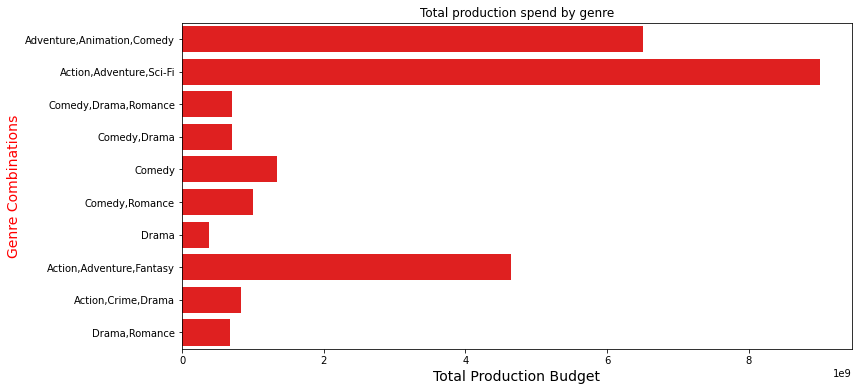

In [31]:
fig, ax = plt.subplots(figsize=(12,6))


sns.barplot(data = top_10_genre_df,
        x = 'total_production_budget',
        y = 'genres',
        color="red",
           orient='h')
# set x-axis label
ax.set_xlabel("Total Production Budget", fontsize = 14)
# set y-axis label
ax.set_ylabel("Genre Combinations",
              color="red",
              fontsize=14)
ax.set_title('Total production spend by genre')
plt.show()

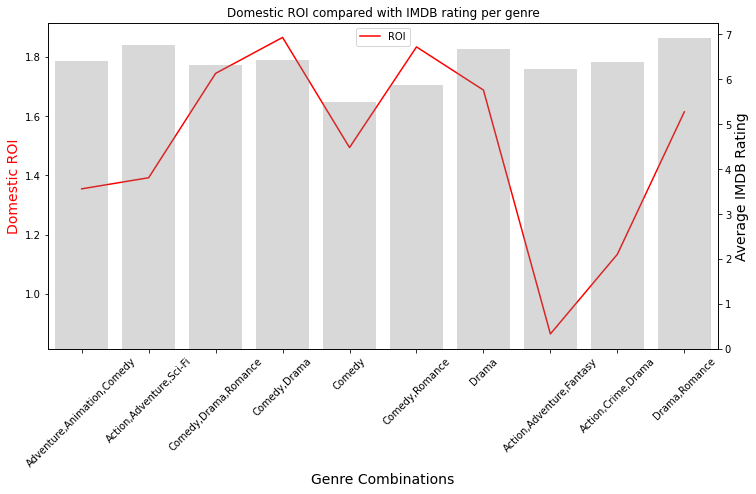

In [32]:
fig, ax = plt.subplots(figsize=(12,6))


sns.lineplot(data = top_10_genre_df,
             x='genres',
             y='domestic_ROI',
        color="red"
            , label='ROI')
# set x-axis label
ax.set_xlabel("Genre Combinations", fontsize = 14)
# set y-axis label
ax.set_ylabel("Domestic ROI",
              color="red",
              fontsize=14)
ax.set_title('Domestic ROI compared with IMDB rating per genre')
plt.legend(loc='upper center')

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
sns.barplot(data = top_10_genre_df, x = 'genres', y = 'average_imdb_rating' , color="grey", alpha=.3)
ax2.set_ylabel('Average IMDB Rating',fontsize=14)
ax.tick_params(axis='x', labelrotation=45)
plt.show()

In [33]:
# Take the profitable films, then understand grouping by year what the average runtime is to know how long to make
# a movie

runtime_df = imdb_tn_movie_and_opening[(imdb_tn_movie_and_opening['is_profitable'] == 1) & (imdb_tn_movie_and_opening['runtime_minutes'].notnull())]
runtime_agg_by_year = runtime_df.groupby('year_of_release')['runtime_minutes'].agg(['count','mean', 'median', 'max']).reset_index()
runtime_agg_by_year

,year_of_release,count,mean,median,max
0,2010,115,106.017391,104.0,148.0
1,2011,115,105.913043,105.0,158.0
2,2012,107,109.046729,105.0,172.0
3,2013,100,112.360000,112.0,180.0
4,2014,106,111.084906,107.0,169.0
5,2015,89,111.932584,109.0,168.0
6,2016,93,108.225806,107.0,161.0
7,2017,82,110.780488,109.0,164.0
8,2018,87,111.942529,110.0,149.0
9,2019,20,112.650000,116.0,133.0


In [34]:
# To understand which month to release movies, first we want to take profitable movies, then
# group by month, taking the sum of production & sum of domestic & worldwide gross

profitable_months_df = imdb_tn_movie_and_opening[imdb_tn_movie_and_opening['is_profitable'] == 1]
month_release_agg_df = profitable_months_df.groupby('month_of_release').agg(count_of_movies=('production_budget','count'), total_production_budget=('production_budget', 'sum')
                                                      ,total_domestic_gross=('domestic_gross', 'sum'), total_worldwide_gross=('worldwide_gross','sum')
                                                      ,total_opening_weekend_rev=('opening_weekend_revenue_left','sum')).reset_index()
# monthly aggregation for opening weekend, gross revenue and production budget

month_release_agg_df['domestic_ROI'] = month_release_agg_df['total_domestic_gross'] /  month_release_agg_df['total_production_budget'] 
month_release_agg_df['overall_ROI'] = month_release_agg_df['total_worldwide_gross'] / month_release_agg_df['total_production_budget']
# calculating ROI without running into avg of avg error

month_release_agg_df['%_of_domestic_ROI_in_opening_weekend'] = month_release_agg_df['total_opening_weekend_rev'] / month_release_agg_df['total_domestic_gross'] * 100.0

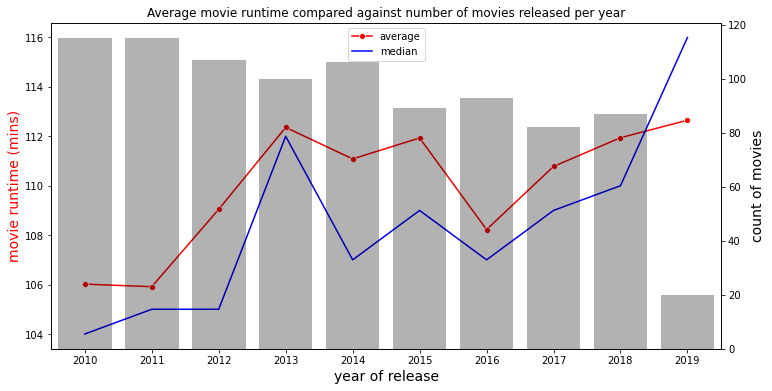

In [35]:
fig, ax = plt.subplots(figsize=(12,6))


sns.lineplot(data = runtime_agg_by_year['mean'],
             color="red",
             marker="o", 
             label='average')
sns.lineplot(data = runtime_agg_by_year['median'],
             color="blue",
             label='median')
plt.legend(loc='upper center')
# set x-axis label
ax.set_xlabel("year of release", fontsize = 14)
# set y-axis label
ax.set_ylabel("movie runtime (mins)",
              color="red",
              fontsize=14)
ax.set_title('Average movie runtime compared against number of movies released per year')

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
sns.barplot(data = runtime_agg_by_year, x = 'year_of_release', y = 'count', color="black", alpha=0.3)
ax2.set_ylabel("count of movies",fontsize=14)
plt.show()

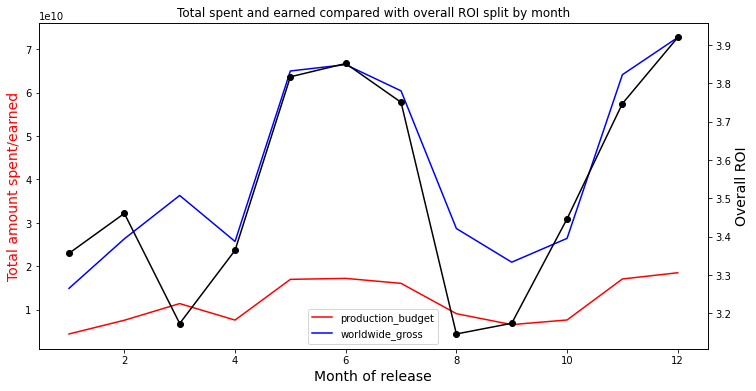

In [36]:
x2 = month_release_agg_df['month_of_release']
y2 = month_release_agg_df['total_production_budget']
z2 = month_release_agg_df['total_worldwide_gross']
q2 = month_release_agg_df['overall_ROI']

fig, ax = plt.subplots(figsize=(12,6))


ax.plot(x2,
        y2,
        color="red", 
       label='production_budget')
ax.plot(x2,
       z2,
       color='blue',
       label='worldwide_gross')
plt.legend(loc='lower center')
# set x-axis label
ax.set_xlabel("Month of release", fontsize = 14)
# set y-axis label
ax.set_ylabel("Total amount spent/earned",
              color="red",
              fontsize=14)
ax.set_title('Total spent and earned compared with overall ROI split by month')

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(x2, q2, color="black",marker="o")
ax2.set_ylabel("Overall ROI",fontsize=14)
plt.show()

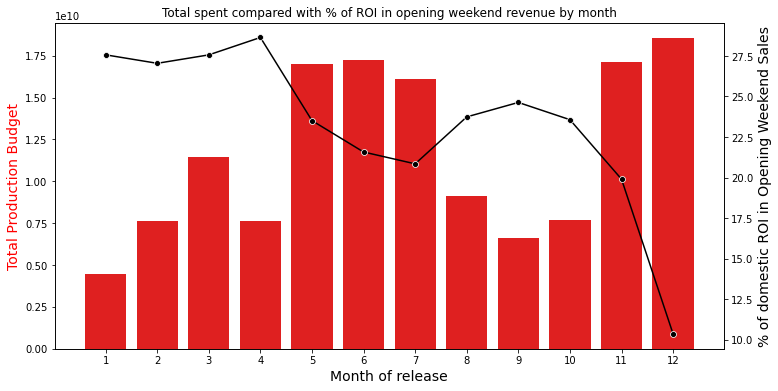

In [37]:
fig, ax = plt.subplots(figsize=(12,6))


sns.barplot(data = month_release_agg_df,
        x = 'month_of_release',
        y = 'total_production_budget',
        color="red")
# set x-axis label
ax.set_xlabel("Month of release", fontsize = 14)
# set y-axis label
ax.set_ylabel("Total Production Budget",
              color="red",
              fontsize=14)
ax.set_title('Total spent compared with % of ROI in opening weekend revenue by month')

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
sns.lineplot(data = month_release_agg_df['%_of_domestic_ROI_in_opening_weekend'], color="black",marker="o")
ax2.set_ylabel("% of domestic ROI in Opening Weekend Sales",fontsize=14)
plt.show()

# Rotten Tomatoes Data Visualisation

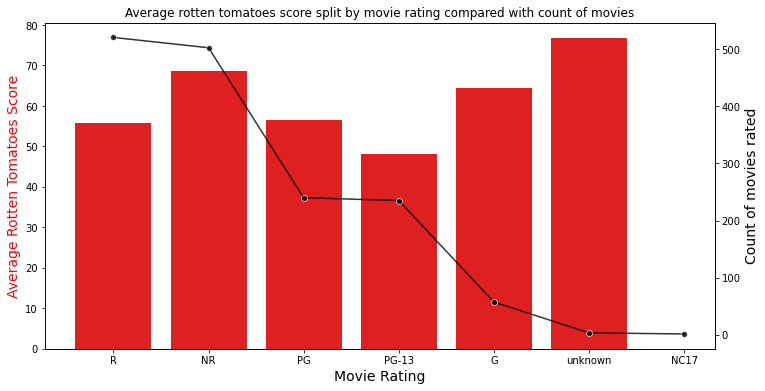

In [38]:

fig, ax = plt.subplots(figsize=(12,6))


sns.barplot(data = aggregate_rating_df,
        x='rating',
        y='avg_overall_rt_score',
        color="red")
# set x-axis label
ax.set_xlabel("Movie Rating", fontsize = 14)
# set y-axis label
ax.set_ylabel("Average Rotten Tomatoes Score",
              color="red",
              fontsize=14)
ax.set_title('Average rotten tomatoes score split by movie rating compared with count of movies')

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
sns.lineplot(data=aggregate_rating_df, 
            y='count_of_movies', 
            x='rating', color="black", marker="o", alpha=0.8)
ax2.set_ylabel("Count of movies rated",fontsize=14)
plt.show()

In [39]:
full_review_data.groupby('is_family_friendly').agg(count_of_movies=('id','count')
                                        , avg_overall_rt_score=('overall_rotten_score', 'mean')
                                        , avg_critic_rt_score=('critic_rotten_score', 'mean')).reset_index().sort_values(by='count_of_movies'
                                                                                                                        , ascending=False)
# creating aggregation by family friendly movies

,is_family_friendly,count_of_movies,avg_overall_rt_score,avg_critic_rt_score
0,0,1028,60.499530,60.043011
1,1,532,53.345881,52.606916


In [41]:
full_review_data.groupby('director').agg(count_of_movies=('id','count')
                                        , avg_overall_rt_score=('overall_rotten_score', 'mean')
                                        , avg_critic_rt_score=('critic_rotten_score', 'mean')).reset_index().sort_values(by='count_of_movies'
                                                                                                                        , ascending=False).head(15)
# seeing which directors have the highest ratings

,director,count_of_movies,avg_overall_rt_score,avg_critic_rt_score
1003,Steven Spielberg,10,77.471172,77.166911
172,Clint Eastwood,8,68.476254,68.003735
1100,William Friedkin,4,63.006922,62.231318
1116,Yimou Zhang,4,73.704037,72.240625
869,Ridley Scott,4,70.901329,71.200835
480,Jim Jarmusch,4,64.547423,60.767045
28,Alfred Hitchcock,4,94.601672,95.509693
1111,Woody Allen,4,86.968580,87.648148
124,Bruce Beresford,4,69.567504,64.874157
1096,William Beaudine,4,100.000000,100.000000


In [42]:
full_review_data.groupby('writer').agg(count_of_movies=('id','count')
                                        , avg_overall_rt_score=('overall_rotten_score', 'mean')
                                        , avg_critic_rt_score=('critic_rotten_score', 'mean')).reset_index().sort_values(by='count_of_movies'
                                                                                                                        , ascending=False).head(15)
# similar to above with writers instead

,writer,count_of_movies,avg_overall_rt_score,avg_critic_rt_score
1059,Woody Allen,4,86.968580,87.648148
492,John Hughes,3,39.270452,37.361586
465,Jim Jarmusch,3,71.777516,70.606061
959,Sylvester Stallone,3,51.937217,47.842208
389,Hong Sang-soo,3,86.666667,85.185185
920,Sidney Sheldon,2,66.666667,66.666667
568,Larry Cohen,2,40.277778,40.277778
257,Don Mancini,2,33.948864,33.518519
772,Peter Morgan,2,45.271498,44.640313
900,Sebastian Gutierrez,2,25.000000,25.000000


## Conclusions
#### Key Findings:
- Movies that aren't family friendly have the higher Rotten Tomatoes score. When broken down deeper we can see this is largely driven from "NR" based movies. The three best rated movie ratings to produce are **G, NR & PG**
- Movies lengths are getting longer over time, make sure to keep your movie **less than 135 minutes** but **over 105-110 minutes**
- The best months to release a movie, varies depending on how quickly you want to get returns. If you care about overall domestic ROI, is June, followed closely by Dec, Jan and Feb. When coupled with what % of sales can be made on the opening weekend, the best two months to release movies on are Jan & Feb, followed by June, due to the massive difference in production budgets.
- In the US, the best ROI genre focuses around **thriller based movies**, due to **low production costs**, in terms of having a large amount of movies with a good domestic ROI, you should focus on Comedy,Drama,Romance based movies.If you also want to consider overall gross, then you should focus on **Action,Adventure,Sci-Fi**.

    - Internationally they should also consider the following genres: 
         - **Adventure,Animation,Comedy**
         - **Action,Adventure,Sci-Fi**
         - **Comedy,Romance**
         - **Drama,Thriller**

#### Limitations:
With the datasets given the limitations occur when trying to connect different data sources together, as there was a loss rate of ***at least 40%*** with each join, meaning the dataset we're able to analyse at the end is only a subset of the data. There were also a lot of other metrics/pieces of relevant information missing that would help enrich the analysis.

#### Future analysis 
- Explore what is the distribution between cinema sales & DVD sales
- Explore what type of movie (animation, etc) drives the best ROI
- See if there is a correlation between rotten tomatoes score & ROI
- What are the most common traits of movies in the top grossing films
- Which countries outside of the US gross the highest % for movies & does it differ by genre? To understand where they should release their movies next & make sure translations are sourced early to increase ROI
- Once defining that G rated movies have the best rating, scrape movie names, directors & writers from that list to get the best performing directors & writers to hire